# Imports

In [1]:
import numpy as np
import pandas as pd
import codecs
import matplotlib.pyplot as plt
import re
import nltk

# Helper functions

In [56]:
def choose_vectorizer(transform_type='tfidf', max_features=5000):
    if transform_type=='tfidf':
        from sklearn.feature_extraction.text import TfidfVectorizer
        vectorizer = TfidfVectorizer(use_idf=True, stop_words=heb_stopwords, max_features=max_features)#, min_df=20, max_df=100)
    elif transform_type=='bow':
        from sklearn.feature_extraction.text import CountVectorizer
        vectorizer = CountVectorizer(stop_words=heb_stopwords, max_features=max_features)
    else:
        vectorizer = None
        
    return vectorizer

def choose_classifier(classification_type='logistic'):
    if classification_type == 'logistic':
        from sklearn.linear_model import LogisticRegression
        classifier = LogisticRegression()

    elif classification_type == 'nb':
        from sklearn.naive_bayes import GaussianNB
        classifier = GaussianNB()
    else:
        classifier = None
    
    return classifier   

# Doing some regex on the docs

In [40]:
# Defining regex to replace and keep in the docs, all excluded will be removed
reg =  "".join(["[^",  
 "\u0590-\u05FF",            # Hebrew
  "\U0001F1E0-\U0001F1FF",    # flags (iOS)
  "\U0001F300-\U0001F5FF",    # symbols & pictographs
  "\U0001F600-\U0001F64F",    # emoticons
  "\U0001F680-\U0001F6FF",    # transport & map symbols
  "\U0001F700-\U0001F77F",    # alchemical symbols
  "\U0001F780-\U0001F7FF",    # Geometric Shapes Extended
  "\U0001F800-\U0001F8FF",    # Supplemental Arrows-C
  "\U0001F900-\U0001F9FF",    # Supplemental Symbols and Pictographs
  "\U0001FA00-\U0001FA6F",    # Chess Symbols
  "\U0001FA70-\U0001FAFF",    # Symbols and Pictographs Extended-A
  "\U00002702-\U000027B0",    # Dingbats
  "\U000024C2-\U0001F251", 
"]"])
sad_smilies = ":\(|\): |🤔|🤨|😐|😑|🙄|😣|😥|😮|🤐|😯|😪|😫|🥱|😒|😓|😔|😕|☹|🙁|😖|😞|😟|😤|😢|😭|😦|😧|😨|😩|🤯|😬|😰|😱|🥵|🥶|😳|😵|😠|😡|🤬|😷|🤒|🤕|🤢|🤮|🤧|🥺|🤥|👿|👺|☠"
happy_smilies = ":\) | \(: |😀|😁|😂|🤣|😃|😄|😅|😆|😉|😊|😋|😎|😍|😘|🥰|😙|😚|😗|☺|🙂|🤗|🤩|😏|😇|🥳|😛|😜|😝|🤤|🤑|🤪|🤠|🤡|🤭|🧐|🤓|💑|👩‍❤️‍👩|👨‍❤️‍👨|💏|👩‍❤️‍💋‍👩|👨‍❤️‍💋‍👨"
regex_pattern = re.compile(reg)

In [41]:
# Testing:
line = 'שלום מה נשמע abc DEF (גבר) :) :) :( ! 😛 😁👍👍🤞😎😢🎉🐱‍👓😢✔👨‍🦰🤶🤦‍♀️😉 '
print(line)
line = re.sub(sad_smilies, '🙁', line)
line = re.sub(happy_smilies, '😀', line)
line2 = " ".join(re.sub(reg, ' ', line).split())
print(line)
print(line2)

שלום מה נשמע abc DEF (גבר) :) :) :( ! 😛 😁👍👍🤞😎😢🎉🐱‍👓😢✔👨‍🦰🤶🤦‍♀️😉 
שלום מה נשמע abc DEF (גבר) 😀😀🙁 ! 😀 😀👍👍🤞😀🙁🎉🐱‍👓🙁✔👨‍🦰🤶🤦‍♀️😀 
שלום מה נשמע גבר 😀😀🙁 😀 😀👍👍🤞😀🙁🎉🐱 👓🙁✔👨 🦰🤶🤦 ♀️😀


# Reading the data

In [42]:
def strip_line(line, y_given=True):
    """
    A function that removes non-alpha characters, single char words, and non hebrew words
    It also removes duplicate letters at the end of a word
    Input:: line
    type:: string
    output:: line ,y
    type:: string
    """
    if y_given == True:
        y = int(line[-1])
        line = line[:-1]
        
    line = re.sub(sad_smilies, '🙁', line)
    line = re.sub(happy_smilies, '😀', line)
    line = re.sub(reg, ' ', line)
#     line = re.sub('[^\u0590-\u05FF]', ' ', line)
#    line = ' '.join([word for word in line.split() if word not in heb_stopwords and len(word)>1])

    if y_given == True:
        return line, y
    else:
        return line
        

In [43]:
# docs is the final dataset that will transform using TF-IDF
def make_docs_y(data, y_given=True):
    docs = []
    if y_given==True:
        y = []
        for line in data:
            doc, y0 = strip_line(line)
            docs.append(doc)
            y.append(y0)
        return docs, np.array(y)
    else:
        for line in data:
            doc = strip_line(line, y_given=False)
            docs.append(doc)
        return docs
        

In [44]:
# Importing Hebrew stopword collection
# heb_stopwords = pd.read_csv('heb_stopwords.txt').values.squeeze()
heb_stopwords = list(pd.read_csv('heb_stopwords.txt').values.squeeze())
important_words_to_keep = ['גרוע','לא','טוב','רע','אין','יפה','שמח','מאמין']
for word in important_words_to_keep:
    if word in heb_stopwords:
        heb_stopwords.remove(word)
stop_words_to_add = ['את']
for word in stop_words_to_add:
    if word not in heb_stopwords:
        heb_stopwords.append(word)
len(heb_stopwords)


491

## Reading

In [45]:
data_train = codecs.open('./data/morph_train.tsv', 'r', 'utf-8').read().splitlines()
data_test = codecs.open('./data/morph_test.tsv', 'r', 'utf-8').read().splitlines()
docs_train, y_train = make_docs_y(data_train)
docs_test, y_test = make_docs_y(data_test)

In [46]:
y_test.shape

(2560,)

# Perform vectorization transformation using sklearn

In [66]:
vectorizer = choose_vectorizer('tfidf', max_features=900)
X_train = vectorizer.fit_transform(docs_train).toarray()
X_test = vectorizer.transform(docs_test).toarray()

In [67]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(10244, 900) (10244,)
(2560, 900) (2560,)


# Training the classifier

In [68]:
classifier = choose_classifier('logistic')
classifier.fit(X_train, y_train)

LogisticRegression()

# Making a confusion matrix

In [69]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred_train = classifier.predict(X_train)
cm_train = confusion_matrix(y_train, y_pred_train)
print(cm_train)
accuracy_score(y_train, y_pred_train)

[[6471  340    3]
 [ 619 2511    2]
 [ 147   94   57]]


0.8823701679031628

In [70]:
y_pred_test = classifier.predict(X_test)
cm_test = confusion_matrix(y_test, y_pred_test)
print(cm_test)
accuracy_score(y_test, y_pred_test)

[[1594  104    0]
 [ 212  577    1]
 [  32   31    9]]


0.8515625

<AxesSubplot:>

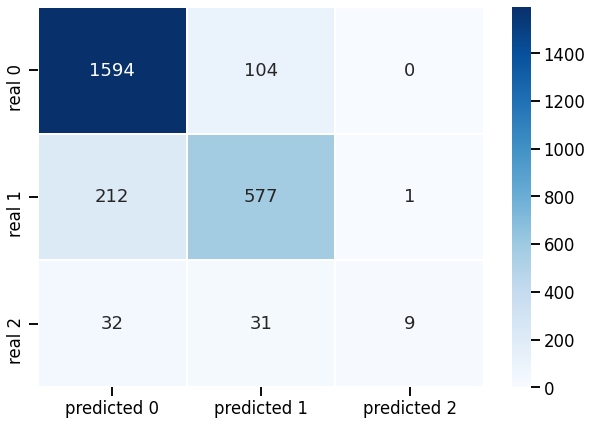

In [71]:
import seaborn as sn
sn.set_context("talk", font_scale=1.0)
df_cm = pd.DataFrame(cm_test, index = ['real 0', 'real 1', 'real 2'],
                  columns = ['predicted 0', 'predicted 1', 'predicted 2'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues", linewidths=2, fmt='g')

In [72]:
# (y_pred_test[y_test == 0] == 0).sum()
# (y_pred_test[y_test == 1] == 1).sum()
# (y_pred_test[y_test == 2] == 2).sum()
(y_pred_test[y_test == 2] == 1).sum()
# (y_pred_test[y_test == 0] == 1).sum()

31

# Some manual checks

In [73]:
manual_check_list = ['😠😠😠🥺 הנשיא ריבלין הוא אידיוט לא מאמין שהצבעתי לך'
         ,'הנשיא הזה הוא בחירה גרועה'
         ,'אני אוהב אותך נשיא יקר'
         ,'זה פשוט חלום אחלה של נזשיא בהצלחה מרובה'
         ,'אכזבה ממישהו שציפיתי שיגיד דעה חדה וברורה מתבייש בך רובי , אכזבת אותי'
         ,'תומך במחבלים שמאלני'
         ]
docs_manual_test = make_docs_y(manual_check_list, y_given=False)

X_check = vectorizer.transform(docs_manual_test).toarray()
y_check = classifier.predict(X_check)



In [74]:
translation_dict = {0: 'Positive', 1: 'negative', 2: 'unknown'}
for line, y in zip(docs_manual_test, y_check):
    print(line, translation_dict[y])
    print('----')

🙁🙁🙁🙁 הנשיא ריבלין הוא אידיוט לא מאמין שהצבעתי לך negative
----
הנשיא הזה הוא בחירה גרועה Positive
----
אני אוהב אותך נשיא יקר Positive
----
זה פשוט חלום אחלה של נזשיא בהצלחה מרובה Positive
----
אכזבה ממישהו שציפיתי שיגיד דעה חדה וברורה מתבייש בך רובי   אכזבת אותי negative
----
תומך במחבלים שמאלני negative
----


# WordCloud

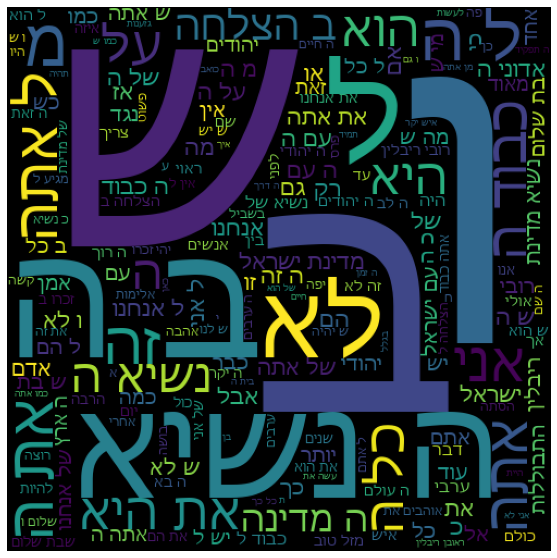

In [93]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from bidi.algorithm import get_display
def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud) 
    plt.axis("off");
text=" ".join(docs_test)

bidi_text = get_display(text)
wordcloud = WordCloud(font_path='./tahoma.ttf',width = 500, height = 500).generate(bidi_text)
plot_cloud(wordcloud)

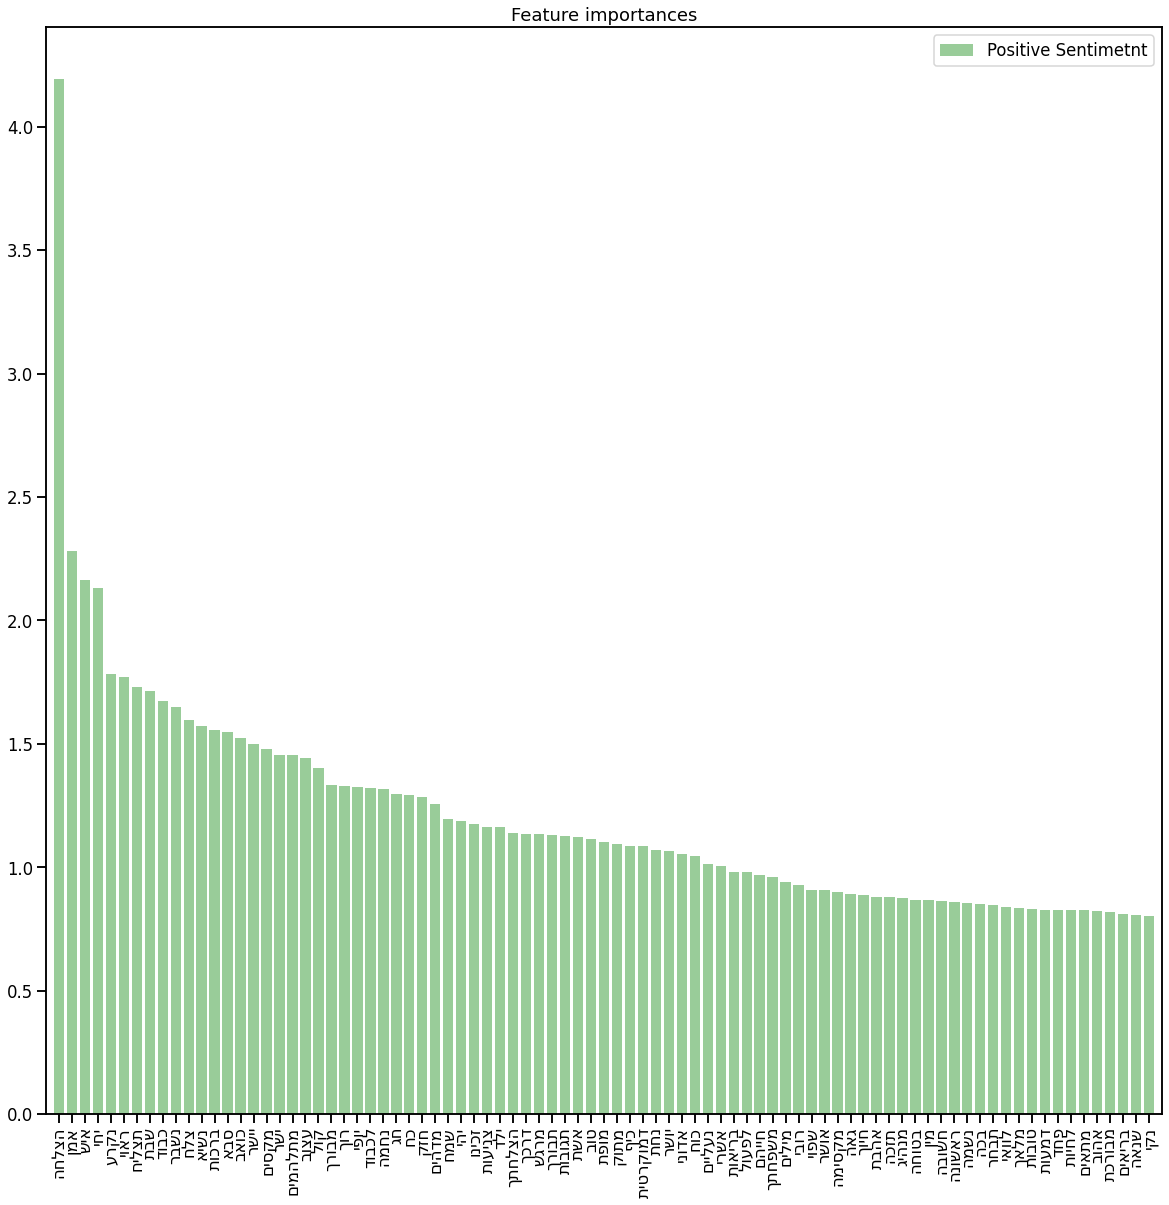

In [170]:
from bidi.algorithm import get_display
feature_names = vectorizer.get_feature_names()
feature_names_inveted = [get_display(word) for word in feature_names]
importances = classifier.coef_
sorted_importances = []
for i in range(3):
    zipped_lists = zip(importances[i], feature_names_inveted)
    sorted_importances.append(dict(sorted(zipped_lists)[::-1]))
feature_count = 85
plt.figure(figsize = (20,20))
plt.title("Feature importances")
plt.bar(range(feature_count), list(sorted_importances[0].keys())[:feature_count], color="g", align="center", label='Positive Sentimetnt', alpha=0.4)
plt.xticks(range(feature_count), list(sorted_importances[0].values())[:feature_count], rotation=90)
plt.xlim([-1, feature_count])
plt.legend()
plt.show()

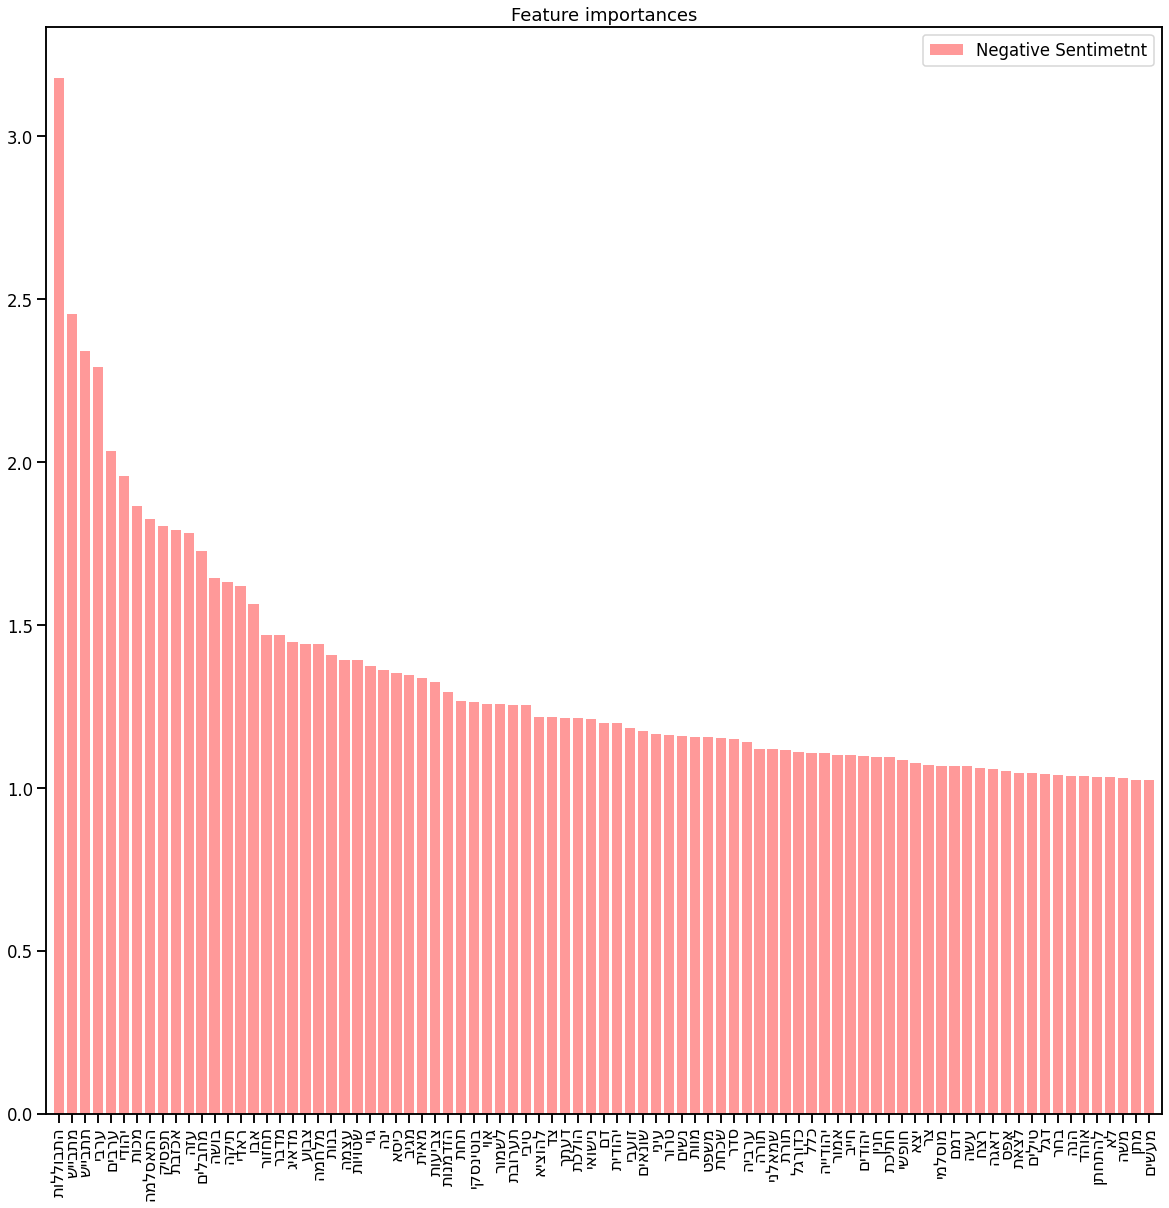

In [171]:
plt.figure(figsize = (20,20))
plt.title("Feature importances")
plt.bar(range(feature_count), list(sorted_importances[1].keys())[:feature_count], color="r", align="center", label='Negative Sentimetnt', alpha=0.4)
plt.xticks(range(feature_count), list(sorted_importances[1].values())[:feature_count], rotation=90)
plt.xlim([-1, feature_count])
plt.legend()
plt.show()

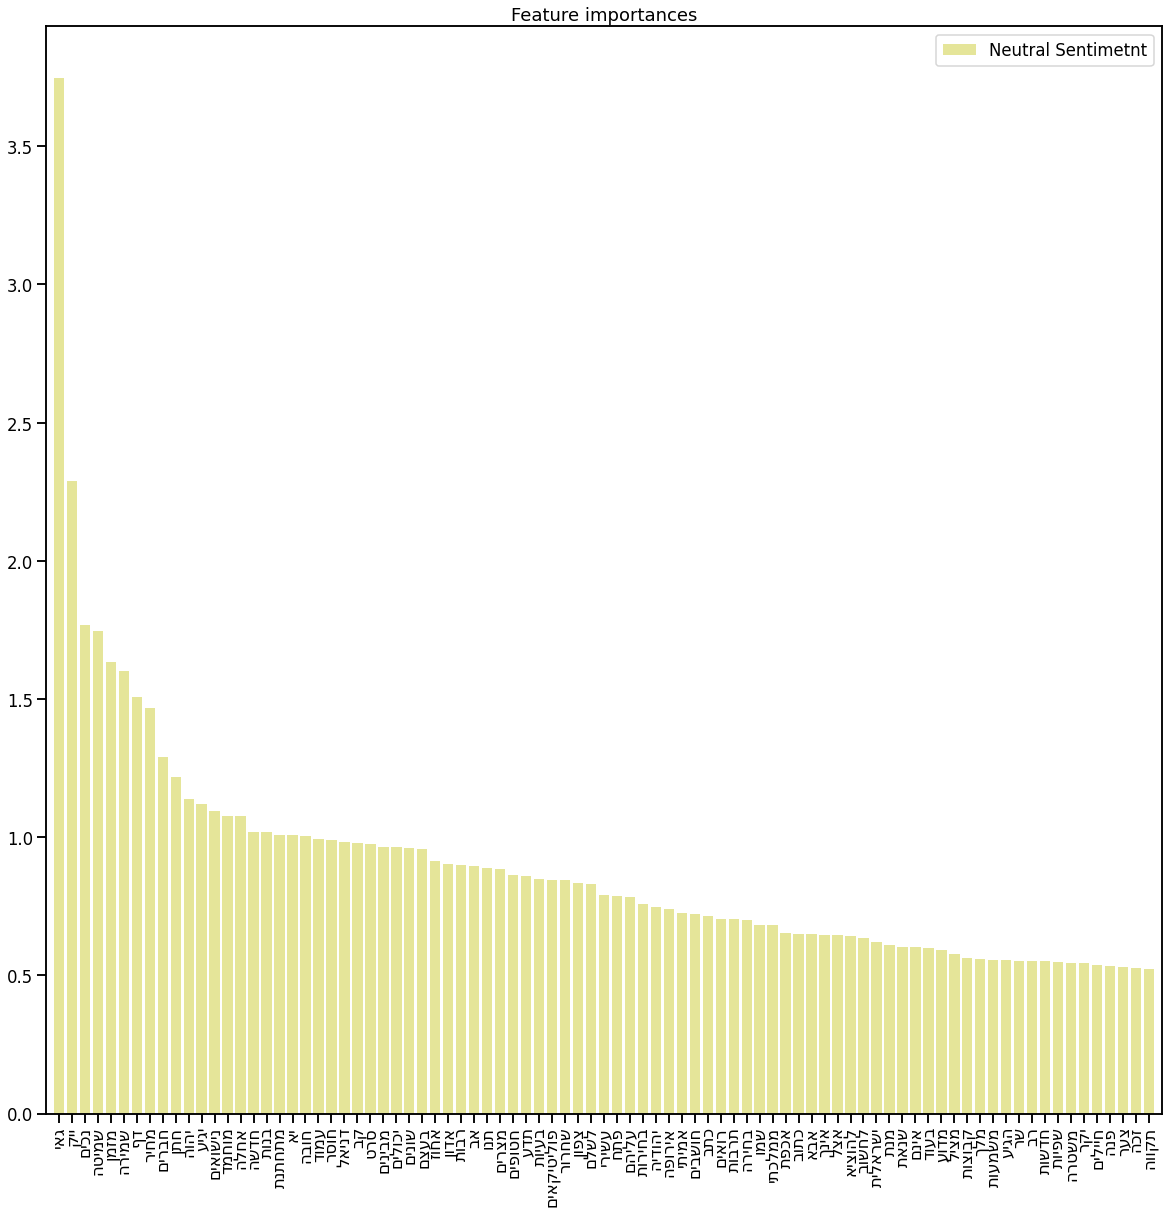

In [173]:
plt.figure(figsize = (20,20))
plt.title("Feature importances")
plt.bar(range(feature_count), list(sorted_importances[2].keys())[:feature_count], color="y", align="center", label='Neutral Sentimetnt', alpha=0.4)
plt.xticks(range(feature_count), list(sorted_importances[2].values())[:feature_count], rotation=90)
plt.xlim([-1, feature_count])
plt.legend()
plt.show()

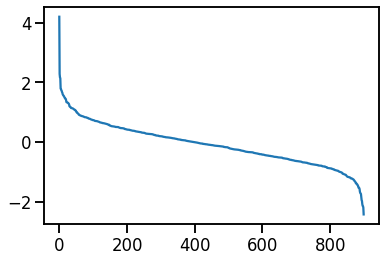

In [119]:
plt.plot(importances[indices])

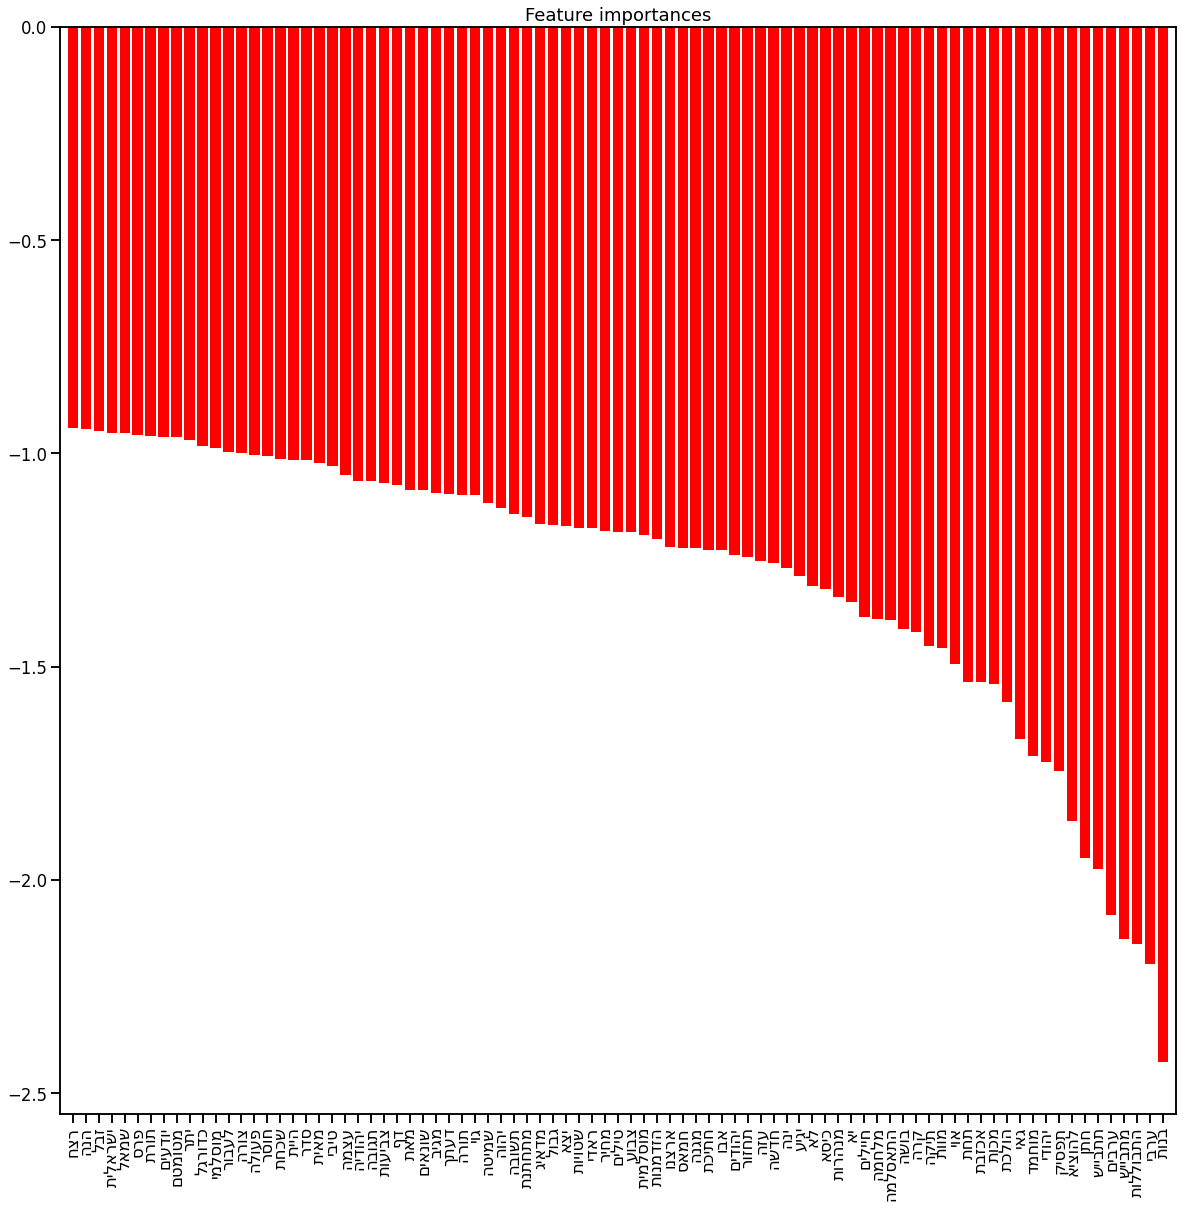

In [151]:
from bidi.algorithm import get_display
feature_names = vectorizer.get_feature_names()
feature_names_inveted = [get_display(word) for word in feature_names]
importances = classifier.coef_[0]
zipped_lists = zip(importances, feature_names_inveted)
sorted_importances_dict = dict(sorted(zipped_lists)[::-1])
feature_count = 85
plt.figure(figsize = (20,20))
plt.title("Feature importances")
plt.bar(range(feature_count), list(sorted_importances_dict.keys())[-feature_count:], color="r", align="center")
plt.xticks(range(feature_count), list(sorted_importances_dict.values())[-feature_count:], rotation=90)
plt.xlim([-1, feature_count])
plt.show()